# Integration with the scientific Python ecosystem 🐍

In this tutorial, we'll try out the integration between PyGMT and other common packages in the scientific Python ecosystem.


Besides [pygmt](https://www.pygmt.org), we'll also be using:

- [GeoPandas](https://geopandas.org/en/stable/) for managing geospatial tabular data
- [Panel](https://panel.holoviz.org/index.html) for interactive visualizations
- [Xarray](https://xarray.dev/) for managing n-dimensional labelled arrays


## Plotting geospatial vector data with GeoPandas and PyGMT

We'll extend the GeoPandas [Mapping and Plotting Tools Examples](https://geopandas.org/en/stable/docs/user_guide/mapping.html) to show how to create choropleth maps using PyGMT.

**References**:

 - GeoPandas User Guide - https://geopandas.org/en/stable/docs/user_guide/

In [1]:
import pygmt
import geopandas as gpd

We'll load sample data provided through the GeoPandas package and inspect the GeoDataFrame.

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


Following the [GeoPandas example](https://geopandas.org/en/stable/docs/user_guide/mapping.html#choropleth-maps), we'll create a Choropleth map showing world population estimates, but will use PyGMT to plot the data using the [Hammer projection](https://www.pygmt.org/latest/projections/misc/misc_hammer.html#hammer).

In [4]:
# Calculate the populations in millions per capita
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
# Change units to Millions
world['pop_est'] = world.pop_est * 1e-6

# Find the range of data values for creating a colormap
cmap_bounds = pygmt.info(data=world['pop_est'], per_column=True)
cmap_bounds

array([1.40000000e-10, 1.37930277e-03])

Now, we'll plot the data on a PyGMT figure, by creating a figure instance, laying down a basemap, plotting the GeoDataFrame, and adding a colorbar!

/import/freenas-m-04-students/fkutschera/miniconda3/envs/egu22pygmt/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


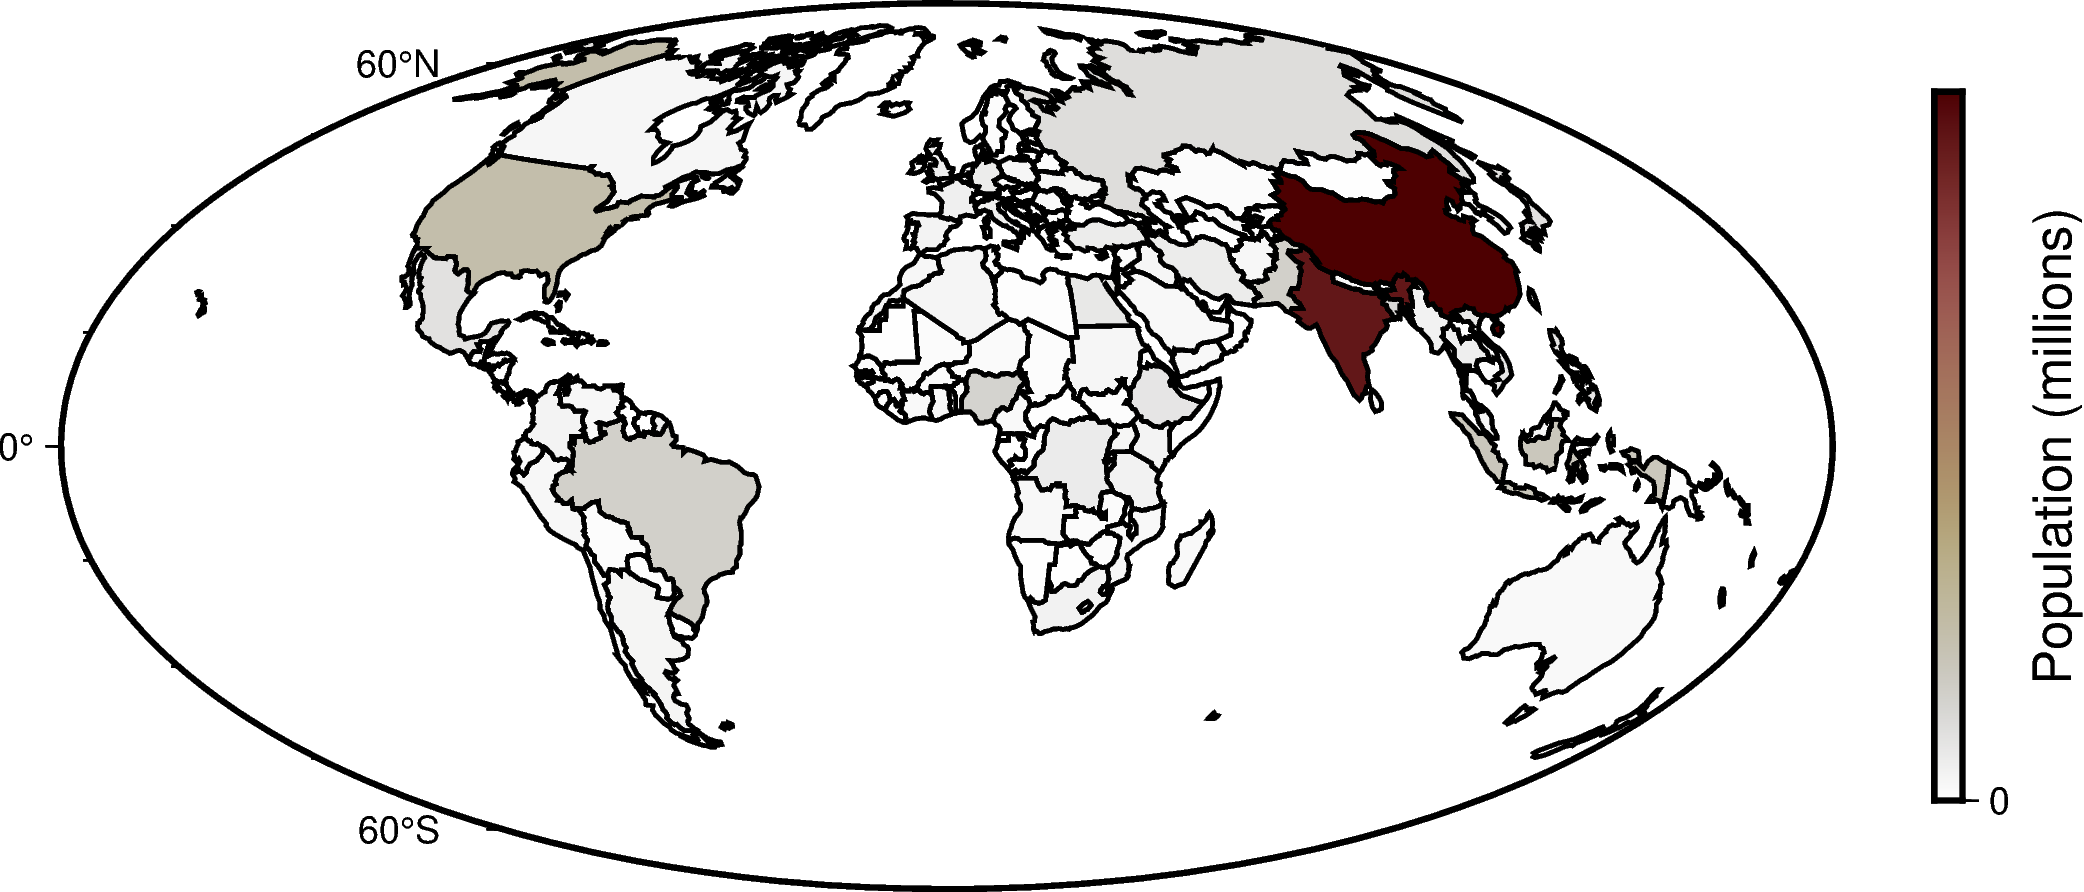

In [5]:
# Create an instance of the pygmt.Figure class
fig = pygmt.Figure()
# Create a colormap for the figure
pygmt.makecpt(cmap="bilbao", series=cmap_bounds)
# Create a basemap
fig.basemap(region="d", projection="H15c", frame=True)
# Plot the GeoDataFrame
# - Use `close=True` to specify that the polygons should be forced closed
# - Plot the polygon outlines with a 1 point, black pen
# - Set that the color should be based on the `pop_est` using the `color, `cmap`, and `aspatial` parameters
fig.plot(data=world, pen="1p,black", close=True, color="+z", cmap=True, aspatial="Z=pop_est")
# Add a colorbar
fig.colorbar(position="JMR", frame='a200+lPopulation (millions)')
# Display the output
fig.show()

## Interactive data visualization with Xarray, Panel, and PyGMT

In this section, we'll create some interactive visualizations of oceanographic data!

We'll use [Panel](https://panel.holoviz.org/index.html), which is a Python library
for connecting interactive widgets with plots! We'll use Panel with
[PyGMT](https://www.pygmt.org) and [xarray](https://www.xarray.dev) to visualize
the objectively interpolated mean field for in-situ temperature from the World Ocean Atlas.

**References**:

- Temperature visualization based on https://rabernat.github.io/intro_to_physical_oceanography/02-c_ocean_temperature_salinity_stratification.html
- Interactive setup based on https://github.com/weiji14/30DayMapChallenge2021/blob/main/day25_interactive.py
- Data from the NOAA World Ocean Atlas, stored on the IRI Data Library at http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.

In [6]:
import panel as pn
import xarray as xr
import pygmt
pn.extension()

In [7]:
# Download the dataset from the IRI Data Library
url = 'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Grid-1x1/.Annual/.temperature/.t_an/data.nc'
netcdf_file = pygmt.which(fname=url, download=True)
woa_temp = xr.open_dataset(netcdf_file).isel(time=0)
woa_temp

<xarray.Dataset>
Dimensions:  (lat: 180, depth: 33, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * depth    (depth) float32 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    time     datetime64[ns] 2008-01-01
Data variables:
    t_an     (depth, lat, lon) float32 ...

grdinfo [WARNING]: Detected a data cube (/import/freenas-m-04-students/fkutschera/programming/egu22pygmt/book/data.nc) but -Q not set - skipping


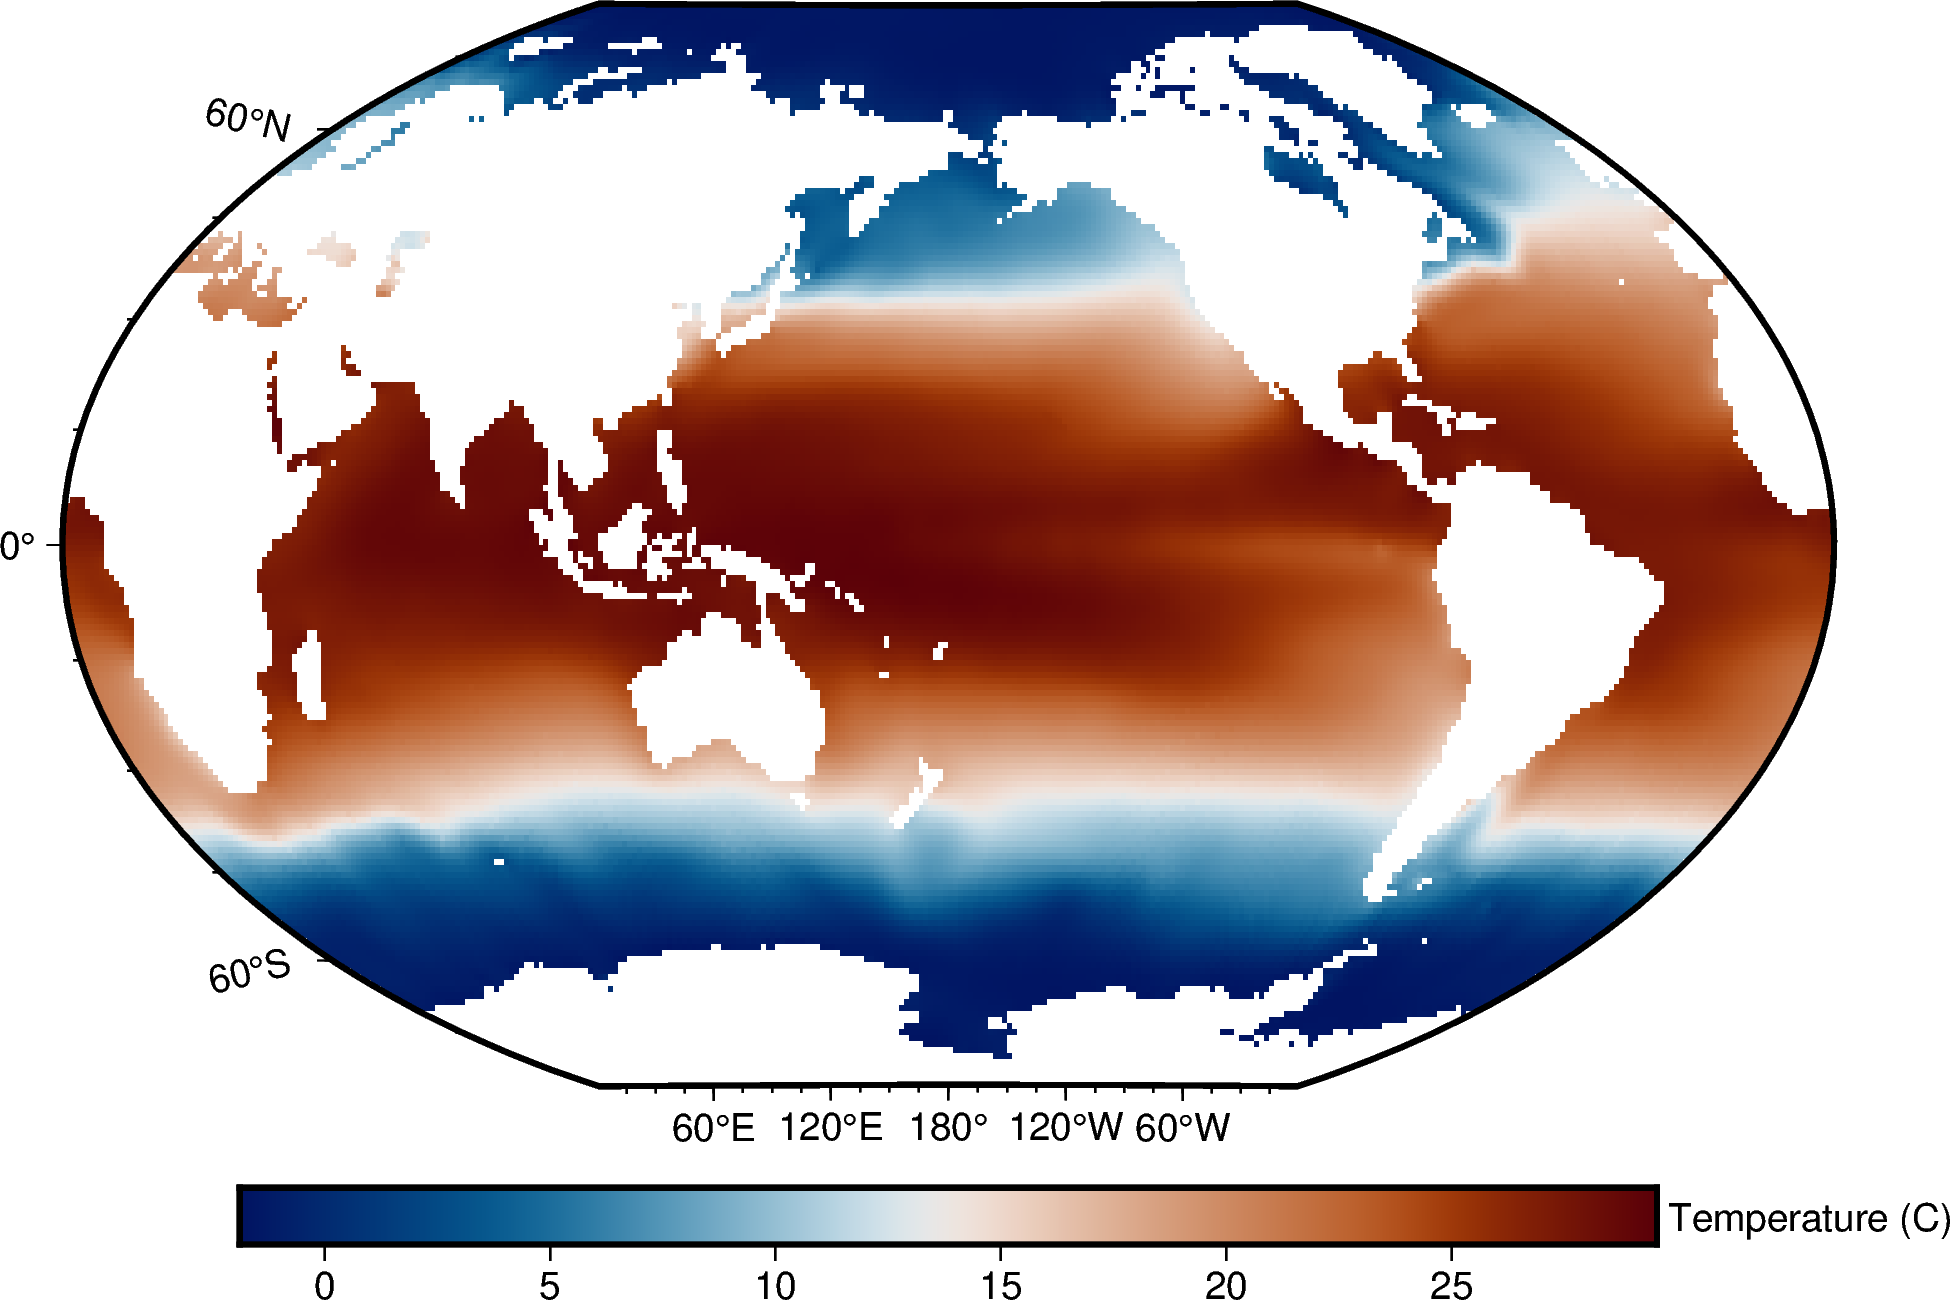

In [15]:
# Make a static plot of sea surface temperature
fig = pygmt.Figure()
fig.grdimage(grid=woa_temp.t_an.sel(depth=0), cmap="vik", projection="R15c", frame=True)
fig.colorbar(frame=["a","y+lTemperature (C)"])
fig.show()

In [17]:
# Make a panel widget for controlling the depth plotted
depth_slider = pn.widgets.DiscreteSlider(name='Depth (m)', 
                                         options=woa_temp.depth.values.astype(int).tolist(), 
                                         value=0)

In [18]:
# Make a function for plotting the depth slice with PyGMT

@pn.depends(depth=depth_slider)
def view(depth: int):
    fig = pygmt.Figure()
    pygmt.makecpt(cmap="vik", series=[-2,30])
    fig.grdimage(grid=woa_temp.t_an.sel(depth=depth), cmap=True, projection="R15c", frame=True)
    fig.colorbar(frame="a5")
    return fig

### Make the interactive dashboard!

Now to put everything together! The 'dashboard' will be very simple.
The 'depth' slider is placed next to the map using `panel.Column`.
Selecting different depths will update the data plotted! Find out more at
https://panel.holoviz.org/getting_started/index.html#using-panel.

Note: This is meant to run in a Jupyter lab/notebook environment.
The grdinfo warning can be ignored.

grdinfo [WARNING]: Detected a data cube (/import/freenas-m-04-students/fkutschera/programming/egu22pygmt/book/data.nc) but -Q not set - skipping


Column
    [0] DiscreteSlider(formatter='%d', name='Depth (m)', options=[0, 10, 20, 30, ...], value=0)
    [1] ParamFunction(function)
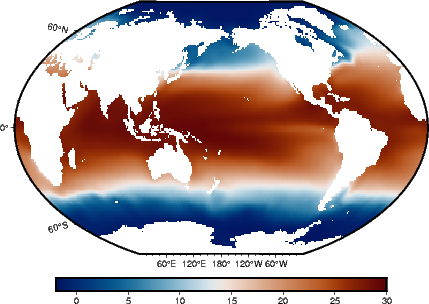

In [19]:
pn.Column(depth_slider, view)